In [4]:
import numpy as np
import io
from sklearn.model_selection import train_test_split

In [5]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# preprocessing


In [6]:
import re

def remove_sortcut(lis,sentence):
    pattern = "[A-Z][A-Z]+"
    match = re.search(pattern, sentence)
    if match:
        s=re.sub(pattern,'',sentence)
        lis.append(s)
    else:
        lis.append(sentence)
seed = 7
np.random.seed(seed)

sentence = []
intents = []
lengths = []
f = io.open('myData.txt',encoding='utf-8')

lines = f.readlines()
for line in lines:
    l = line.split('||')
    k = l[:1]
    j = l[1:]

    for i in j:
        ii = i.strip()
        intents.append(ii)

    for i in k:
        remove_sortcut(sentence,i)
        
f.close()
# convert to lowercase
sentences=[item.lower() for item in sentence]  
print('num of sentences ',len(sentences))
print('num of intents ',len(intents))

labels = []
label = ['greeting','inqueryService', 'dateService', 'beQuestion', 'placeService', 'getService', 'quantityService']
dictionary = dict(zip(label, range(len(label))))
print(dictionary)
for it in intents:
    if it in dictionary.keys():
        labels.append(dictionary.get(it))
print(dictionary.keys())
print(sentences[:3])
print(intents[:3])

num of sentences  8124
num of intents  8124
{'greeting': 0, 'getService': 5, 'inqueryService': 1, 'quantityService': 6, 'placeService': 4, 'dateService': 2, 'beQuestion': 3}
dict_keys(['greeting', 'getService', 'inqueryService', 'quantityService', 'placeService', 'dateService', 'beQuestion'])
['so, how are you doing today? ', 'hi there.', 'hello.']
['greeting', 'greeting', 'greeting']


# split data

In [7]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split( sentences, intents, test_size=0.33, random_state=random_state,shuffle=True)
print(len(X_train), "for train ")
print(len(X_test), "for test ")
print(y_test[:3])

5443 for train 
2681 for test 
['beQuestion', 'inqueryService', 'inqueryService']


# features
1. bag of words  : for our example. Briefly, we segment each text file into words (for English splitting by space), and count # of times each word occurs in each document and finally assign each word an integer id. Each unique word in our dictionary will correspond to a feature (descriptive feature).using CountVectorizer()

2. TF - Term Frequencies : Just counting the number of words in each document has 1 issue: it will give more weightage to longer documents than shorter documents. To avoid this, we can use frequency (TF - Term Frequencies) i.e. #count(word) / #Total words, in each document. 

3. TF-IDF: Finally, we can even reduce the weightage of more common words like (the, is, an etc.) which occurs in all document. This is called as TF-IDF i.e Term Frequency times inverse document frequency. use TfidfTransformer()


# Naive Bayes classifier

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


# Extracting features
  with preprocessing : remove stopwords and  stemming 
  without remove stopwords and  stemming

In [9]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
    
    
    
bayes_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())
                      ])

#remove stopword and stemming
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

bayes_clf_stop_stem = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('mnb', MultinomialNB(fit_prior=True))])




# fitting

In [10]:
bayes_clf.fit(X_train, y_train)
predicted = bayes_clf.predict(X_test)
print('Naive Bayes  %f' %(np.mean(predicted == y_test)))
print('Naive Bayes error : {:4.2f} '.format(1 - metrics.accuracy_score(y_test, predicted)))

bayes_clf_stop_stem.fit(X_train, y_train)
predicted_stop_stem = bayes_clf_stop_stem.predict(X_test)
print('Naive Bayes with remove stopwords and stemming %f' %(np.mean(predicted_stop_stem == y_test)))
print('Naive Bayes error with stem and stop : {:4.2f} '.format(1 - metrics.accuracy_score(y_test, predicted_stop_stem)))




Naive Bayes  0.665423
Naive Bayes error : 0.33 
Naive Bayes with remove stopwords and stemming 0.535621
Naive Bayes error with stem and stop : 0.46 


# Grid search

In [12]:
parameters_NB = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False)}
gs_clf_NB = GridSearchCV(bayes_clf, parameters_NB, n_jobs=-1)
gs_clf_NB = gs_clf_NB.fit(X_train, y_train)
print(gs_clf_NB.best_score_)
print(gs_clf_NB.best_params_ )

0.6880396839977954
{'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [13]:
from sklearn.linear_model import SGDClassifier
bayes_clf = Pipeline([('vect_', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('mnb', MultinomialNB(fit_prior=True))
  
])

bayes_clf.fit(X_train, y_train)
predicted = bayes_clf.predict(X_test)
print('Naive Bayes  %f' %(np.mean(predicted == y_test)))
print('Naive Bayes error : {:4.2f} '.format(1 - metrics.accuracy_score(y_test, predicted)))

Naive Bayes  0.707199
Naive Bayes error : 0.29 


c:\users\shayma2\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

     beQuestion       0.88      0.84      0.86       971
    dateService       1.00      0.05      0.10       210
     getService       0.00      0.00      0.00       211
       greeting       0.00      0.00      0.00        23
 inqueryService       0.61      0.98      0.75      1089
   placeService       1.00      0.02      0.05        82
quantityService       0.00      0.00      0.00        95

    avg / total       0.68      0.71      0.63      2681

Confusion matrix, without normalization
[[ 820    0    0    0  151    0    0]
 [  46   11    0    0  153    0    0]
 [   9    0    0    0  202    0    0]
 [   5    0    0    0   18    0    0]
 [  26    0    0    0 1063    0    0]
 [  11    0    0    0   69    2    0]
 [  10    0    0    0   85    0    0]]
None


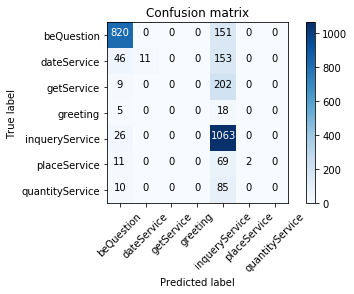

In [14]:
classes= ['beQuestion','dateService','getService','greeting','inqueryService','placeService','quantityService']
print(metrics.classification_report(y_test, predicted))
cm_svm = confusion_matrix(y_test, predicted)

print(plot_confusion_matrix(cm_svm,classes=classes))

# SVM


In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.externals import joblib



# Extracting features _ svm

In [18]:
svm_clf = Pipeline([('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, random_state=random_state)),
])


# with stemming and remove stopwords
svm_clf_stop_stem = Pipeline([('vect', stemmed_count_vect),   ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, random_state=random_state)),
])



# fitting

In [19]:
svm = svm_clf.fit(X_train, y_train)
predicted = svm_clf.predict(X_test)
print('SVM correct prediction: {:4.2f}'.format(np.mean(predicted == y_test)))



#with remove stopword and stemming 
svm_stem_stop = svm_clf_stop_stem.fit(X_train, y_train)
predicted_ss = svm_stem_stop.predict(X_test)
print('SVM correct prediction with (stemming ,stopwords) : {:4.2f}'.format(np.mean(predicted_ss == y_test)))

SVM correct prediction: 0.86
SVM correct prediction with (stemming ,stopwords) : 0.57


# Grid search

In [20]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}
gs_clf_svm = GridSearchCV(svm_clf, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_ )

0.8623920632004409
{'tfidf__use_idf': False, 'vect__ngram_range': (1, 2), 'clf__alpha': 0.001}


# final model

In [21]:
svm_clf = Pipeline([('vect_', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=9, random_state=random_state)),
])

svm = svm_clf.fit(X_train, y_train)
predicted = svm_clf.predict(X_test)
print('SVM accuracy: {:4.2f}'.format(np.mean(predicted == y_test)))
# error
print('SVM error : {:4.2f} '.format(1 - metrics.accuracy_score(y_test, predicted)))


SVM accuracy: 0.87
SVM error : 0.13 


c:\users\shayma2\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

     beQuestion       0.92      0.97      0.94       971
    dateService       0.88      0.82      0.85       210
     getService       0.66      0.39      0.49       211
       greeting       0.00      0.00      0.00        23
 inqueryService       0.85      0.91      0.88      1089
   placeService       0.89      0.99      0.94        82
quantityService       0.88      0.63      0.74        95

    avg / total       0.85      0.87      0.86      2681

Confusion matrix, without normalization
[[938  12   1   0  17   1   2]
 [  2 173   0   0  28   2   5]
 [ 21   1  83   0 104   1   1]
 [ 19   0   0   0   4   0   0]
 [ 41   6  41   0 995   6   0]
 [  1   0   0   0   0  81   0]
 [  3   4   0   0  28   0  60]]
None


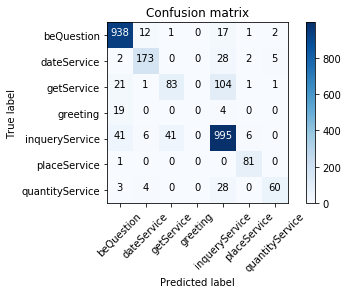

In [23]:
classes= ['beQuestion','dateService','getService','greeting','inqueryService','placeService','quantityService']
print(metrics.classification_report(y_test, predicted))
cm_svm = confusion_matrix(y_test, predicted)

print(plot_confusion_matrix(cm_svm,classes=classes))

In [41]:
#http://blog.chapagain.com.np/python-graph-plotting-with-matplotlib-line-graph/
# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/ 